# This notebook will help fix the Peterson Algorithm, hopefully making it run much faster. 

In [1]:
## Import statements
import xarray
import numpy as np
import pyart
import metpy.calc as metcalc
from metpy.units import units
import proplot as pplt

import math
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from PIL import Image

import os, glob
import wildfire2 as wf2

import datetime
from netCDF4 import Dataset as ncDataset
import cartopy.crs as ccrs
import pyproj
import rasterio.crs
from rasterio import Affine
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
import numpy.ma as ma

import shapely
from shapely import geometry
from matplotlib import cm
import fiona

import satpy.modifiers.parallax as smp

from cartopy_map_utils import proj4_to_cartopy
import model as md
import echotop as et


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/196/jv1871/echotop.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cloud_top_height(
/home/196/jv1871/echotop.py:132: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def column_max_reflectivity(r, azimuth, elevation, st_sweep, ed_sweep, refl):


In [2]:
## Louis' version of the Peterson algorithm -- what needs to be updated.
def peterson_algo(BT4, BT11, BT13, T, Hu, sza) :
    '''
    Peterson's algorithm.
    -- Parameters --
    * BT4, BT11, BT13 [array] : brightness temperatures, expressed in °C
    * T [array] : temperature at 1000hPa from Copernicus's dataset (°C)
    * Hu [array] : humidity at 1000hPa from Copernicus's dataset (%)
    * sza [array] : solar zenith angle (in  degrees)
    -- Returns a number [array] indicating the group in which the pixel belongs (cf Peterson's article).
    Detail of groups :
    1 : no daytime deep convection
    2 : deep convection or thin high clouds
    3 : marginal PyroCb (MPCB)
    4 : intense pyroCb (IPCB)
    '''
    if sza >= 80 :
        return 1
    elif BT11 >= -20 :
        return 1
    else :
        if (BT11 - BT13) >= 3 :
            return 2
        else : # LCL loop
            LCL_T, LCL_H = compute_LCL(T, Hu)
            if (LCL_T < 0) or (LCL_H > 3000) : # "Yes" part of the LCL loop
                if (BT4 - BT11) <= 60 :
                    if (BT4 - BT11) > 50 :
                        if BT11 < -35 :
                            return 4
                        else :
                            return 3
                    else :
                        return 2
                else :
                    if BT11 < -35 :
                        return 4
                    else :
                        return 3
            else : # "No" part of the LCL loop
                if BT4 - BT11 > 50 :
                    if BT11 < -35 :
                        return 4
                    else :
                        return 3
                else :
                    return 2

In [3]:
## This method gets the satellite data for a particular channel.
## It then returns the data for the channel in question and the resolution.
def getSatelliteData(year, month, day, time, channel):
    path_sat = f'/g/data/ra22/satellite-products/arc/obs/himawari-ahi/fldk/latest/{year}/{month}/{day}/{time}/'
    if (channel == 'f1'):
        ## Visible Channels
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B01-PRJ_GEOS141_1000-HIMAWARI8-AHI.nc'))
        resolution = 1000
        return (data, resolution)
    elif (channel == 'f2'):
        ## Part of Visible Channels
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B02-PRJ_GEOS141_1000-HIMAWARI8-AHI.nc'))
        resolution = 1000
        return (data, resolution)
    elif (channel == 'f3'):
        ## Part of Visible Channels
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B03-PRJ_GEOS141_500-HIMAWARI8-AHI.nc'))
        resolution = 500
        return (data, resolution)
    elif (channel == 'f7'):
        ## Brightness Temperature 4µm channel 
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B07-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'f14'):
        ## Brightness Temperature 11µm channel
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'f16'):
        ## Brightness Temperature 13µm channel
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B16-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'f4'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B04-PRJ_GEOS141_1000-HIMAWARI8-AHI.nc'))
        resolution = 1000
        return (data, resolution)
    elif (channel == 'f5'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B05-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'f6'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B06-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'f13'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_OBS_B13-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'fr1'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_CREFL_B01-PRJ_GEOS141_1000-HIMAWARI8-AHI.nc'))
        resolution = 1000
        return (data, resolution)
    elif (channel == 'fr2'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_CREFL_B02-PRJ_GEOS141_1000-HIMAWARI8-AHI.nc'))
        resolution = 1000
        return (data, resolution)
    elif (channel == 'fr3'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_CREFL_B03-PRJ_GEOS141_500-HIMAWARI8-AHI.nc'))
        resolution = 500
        return (data, resolution)
    elif (channel == 'fr4'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_CREFL_B04-PRJ_GEOS141_1000-HIMAWARI8-AHI.nc'))
        resolution = 1000
        return (data, resolution)
    elif (channel == 'fr5'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_CREFL_B05-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'fr6'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_CREFL_B06-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'f_sza'):
        data = np.squeeze(xarray.open_dataset(path_sat + f'{year}{month}{day}{time}00-P1S-ABOM_GEOM_SOLAR-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'))
        resolution = 2000
        return (data, resolution)
    elif (channel == 'ctth'):
        path_para = f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/cloud/ctth/{year}/{month}/{day}/'
        f_para = path_para + f'S_NWC_CTTH_HIMA08_HIMA-N-NR_{year}{month}{day}T{time}00Z.nc'
        data = xarray.open_dataset(f_para)
        return (data, np.nan)

In [4]:
## This is a new upGird method that will take an array of a certain size (originalSize) and make it larger (newSize).
## This new method should have a O(n) runnign time, beating the previous O(n^2) running time.
def newUpGrid(data, originalSize, newSize):
    ## Calculates by what factor the newArray needs to be larger by.
    conversion_factor = int((newSize/originalSize))
    ## For the first step, only the columns will be made larger. The rows will be left intact.
    step1 = np.zeros((newSize, originalSize))
    i_counter = 0
    ## Manually adjusts the columns of newArray with data from the previous old array.
    ## i_counter acts as a way to determine which particular row from newArray gets copied.
    for i in range(newSize):
        ## Only every conversion_factor time (i.e. 2nd or 4th time) does the i_counter need to be updated. For all other times, it is simply re-reading the data from the previous row.
        if (i % conversion_factor == 0):
            i_counter += 1
        step1[i,:] = data[i_counter-1, :]
    ## For the second (and final) step, the new rows will be made for the larger array, thereby completing the upsizing.
    final = np.zeros((newSize, newSize))
    i_counter = 0
    ## Manually
    for i in range(newSize):
        ## Only every conversion_factor time (i.e. 2nd or 4th time) does the i_counter need to be updated. For all other times, it is simply re-reading the data from the previous row.
        if (i % conversion_factor == 0):
            i_counter += 1
        final[:,i] = step1[:, i_counter-1]
        
    return final

In [33]:
## This methid will upgrid a non-square array, given the original sizes, newSizes, and of course the data.
def RectangleUpGrid(data, originalI, originalJ, newI, newJ):
    ## Calculates the conversion factors for the corresponding sides.
    i_conversion_factor = int((newI/originalI))
    j_conversion_factor = int((newJ/originalJ))
    step1 = np.zeros((newI, originalJ))
    ## Scaling up i axis first
    i_counter = 0
    ## Manually adds each new element into step1.
    for i in range(newI):
        ## Only updates the i_counter for every conversion_factorth iteration (i.e. only needs to be updated for every 2nd, 4th, etc iteration)
        if (i % i_conversion_factor == 0 and i_counter < originalI):
            i_counter += 1
        step1[i,:] = data[i_counter-1, :]
    final = np.zeros((newI, newJ))

    ## Now scaling up j axis
    i_counter = 0
    ## Manually adds each new element into final array.
    for i in range(newJ):
        ## Only updates the i_counter for every conversion_factorith iteration (i.e. only needs to be updated for every 2nd, 4th, etc... iteration)
        if (i % j_conversion_factor == 0 and i_counter < originalJ):
            i_counter += 1
        final[:,i] = step1[:, i_counter-1]
    return final

In [6]:
## This is a method to scale up the x and y values of an array from originalSize to a bigger newSize.
def upGridXY(old_x, old_y, originalSize, newSize):
    ## Conversion factor determines the factor that the new array is being changed by.
    conversion_factor = int((newSize/originalSize))
    newX = np.zeros(newSize)
    newY = np.zeros(newSize)
    counter = 0
    ## Goes through the newArray and manually adds each element into the new data array.
    for i in range(newSize):
        newX[i] = old_x[counter-1]
        newY[i] = old_y[counter-1]
        ## Only on every conversion_factorith iteration (i.e. 2nd or 4th) does the coutner need to be updated. For all other times, it simply rereads the data from the last run.
        if (i % conversion_factor == 0):
            counter += 1
    finalX = np.zeros(newSize)
    finalY = np.zeros(newSize)
    finalX[0:-1] = newX[1:]
    finalX[-1] = newX[0]

    ## As a result of my incompetence (and it's a very easy fix in the above code), the first element should be in the last position in the array. The below process works to make this happen in each of the Y and X arrays. 
    finalY[0:-1] = newY[1:]
    finalX[-1] = newX[0]
    return finalX, finalY

In [7]:
## This is a new method to filter the data based on desired laittude and longitude coordinates. The only inputs are the coordinates, x, and y values of the array.
def newFilterData(data, minLat, maxLat, minLon, maxLon, x, y):
    ## This is a new method to filter the data based on desired laittude and longitude coordinates. The only inputs are the coordinates, x, and y values of the array.
    f_sza = getSatelliteData(year, month, day, time, 'f_sza')[0]
    ## Convert to a pyproj object.
    fsza_proj4string = f_sza.geostationary.proj4
    p = pyproj.Proj(fsza_proj4string)

    ## Find the x and y values associated with the two opposite corners of the image.
    x1, y2 = p(minLon, minLat)
    x2, y1 = p(maxLon, maxLat)
    ## Finds the position that is closest to the x and y values calculated above.
    x1Index = (np.abs(x - x1)).argmin()
    x2Index = (np.abs(x - x2)).argmin()
    y1Index = (np.abs(y - y1)).argmin()
    y2Index = (np.abs(y - y2)).argmin()

    ##Throughout the dataset, y comes first and then x, so it is therefore necessary to flip the output of y and x as a result of how this was programmed. 
    ## Actually performed
    newData = data[y1Index:y2Index, x1Index:x2Index]
    newX = x[x1Index:x2Index]
    newY = y[y1Index:y2Index]
    return (newData, newY, newX)

In [8]:
## This method will perform parallax correction on a high-resolution image. The only inputs are the dataset in question, coordinates and date/time.
def get_HighRes_shifted_array(data, minLat, maxLat, minLon, maxLon, year, month, day, time):
    ## Get data corresponding to ctth - cloud top height
    ctth = getSatelliteData(year, month, day, time, "ctth")[0]
    ctth_data = ctth['ctth_alti'].values
    ctth_x = ctth['nx'].values
    ctth_y = ctth['ny'].values
    ## The cloud top height data needs to be transformed into a higher resolution dataset. To do this, it needs to be upgrided to a resolution of 500m.
    nctth = newUpGrid(ctth_data, len(ctth_x), 22000)
    nx, ny = upGridXY(ctth_x, ctth_y, len(ctth_x), 22000)


    ## Filters the data using the desired coordinates
    new_ctth, new_nx, new_ny = newFilterData(nctth, minLat, maxLat, minLon, maxLon, 
                                          nx, ny)

    ## Gets the solar zenith angle dataset for projection information.
    f_sza = getSatelliteData(year, month, day, time, 'f_sza')[0]
    fsza_proj4string = f_sza.geostationary.proj4
    ## Create a pyproj object to extract longitude (center of satellite) and height of the satellite.
    b = pyproj.CRS.from_string(fsza_proj4string)
    a = b.to_dict()
    lat = a['lon_0']
    height = a['h']

    ## Calculates the latitude and longitue from the x and y values of the array.
    lat2d, lon2d = md.calc_lat_lon_from_proj(fsza_proj4string, new_nx, new_ny)
    ## Finds the correct latitude and longitude for each pixel within the specified array.
    corr_lon, corr_lat = smp.get_parallax_corrected_lonlats(lat, 0, height, lon2d, lat2d, new_ctth)

    ## Calculates the shift needed on each pixel.
    shift_lon = corr_lon - lon2d
    shift_lat = corr_lat - lat2d
    
    n, m = shift_lon.shape
    shift_500 = np.empty((n, m, 2))
    shift_500[:, :, 0] = shift_lon
    shift_500[:, :, 1] = shift_lat
    ## Uses Louis' method to convert the shift from latitude/longitude coordinates into x/y coordinates.
    shift_m_500 = md.get_shift_xy(shift_500, lon2d, lat2d, corr_lon, corr_lat)
    ## Uses Louis' method to actually perform the shift.
    shifted_arr = md.get_shifted_arr(shift_500, shift_m_500, data, 500)

    return shifted_arr

In [9]:
## This method will perform parallax correction on a desired dataset. The inputs are the coordinates, date and time, as well as the dataset in question
## NOTE: This method assumes a resolution of 2000m!
def get_shifted_array(data, desiredMinLat, desiredMaxLat, desiredMinLon, desiredMaxLon, year, month, day, time):
    ## Gets satellite data associated with ctth - Cloud Top Height
    ctth = getSatelliteData(year, month, day, time, "ctth")[0]
    ctth_data = ctth['ctth_alti'].values
    ctth_x = ctth['nx'].values
    ctth_y = ctth['ny'].values

    ## Filters the new cloud top height dataset using the filter method. 
    new_ctth, new_nx, new_ny = newFilterData(ctth_data, desiredMinLat, desiredMaxLat, desiredMinLon, desiredMaxLon, 
                                          ctth_x, ctth_y)
    ## Get solar zenith angle dataset to get projection information.
    f_sza = getSatelliteData(year, month, day, time, 'f_sza')[0]
    fsza_proj4string = f_sza.geostationary.proj4
    ## Create a pyproj object to extract the longitude (center of satellite) and height of the satellite.
    b = pyproj.CRS.from_string(fsza_proj4string)
    a = b.to_dict()
    lat = a['lon_0']
    height = a['h']

    ## Calcualtes the latitude and longitude from the x and y values of the array.
    lat2d, lon2d = md.calc_lat_lon_from_proj(fsza_proj4string, new_nx, new_ny)
    ## Finds the correct latitude and longitude for each pixel within the specified array.
    corr_lon, corr_lat = smp.get_parallax_corrected_lonlats(lat, 0, height, lon2d, lat2d, new_ctth)

    ## Calculates the shift needed on each pixel.
    shift_lon = corr_lon - lon2d
    shift_lat = corr_lat - lat2d
    
    n, m = shift_lon.shape
    shift_2000 = np.empty((n, m, 2))
    shift_2000[:, :, 0] = shift_lon
    shift_2000[:, :, 1] = shift_lat
    ## Uses Louis' method to convert the shift from latitude/longitude coordinates into x/y coordinates.
    shift_m_2000 = md.get_shift_xy(shift_2000, lon2d, lat2d, corr_lon, corr_lat)

    ## Uses Louis' method to actually peform the shift.
    shifted_arr = md.get_shifted_arr(shift_2000, shift_m_2000, data, 2000)
    return shifted_arr



In [10]:
## Interpolates the data using Louis' method.
def interpolate(data):
    try :
        interpolated_data = md.interpolate_missing_pixels(data, np.isnan(data), method = 'nearest')
    except Exception as e :
        print("Here")
        interpolated_data = data

    return interpolated_data

In [11]:
## This method will get the x and y boundaries for the specified lat and lon given.
def getXYBoundaries(minLat, maxLat, minLon, maxLon):
    ## This will get the solar zenith angle data for the array. This channel is commonly used for projection information.
    f_sza = getSatelliteData(year, month, day, time, 'f_sza')[0]
    ## Convert to a pyproj object.
    fsza_proj4string = f_sza.geostationary.proj4
    p = pyproj.Proj(fsza_proj4string)

    ## Find the x and y values associated with the two opposite corners of the image.
    x1, y2 = p(minLon, minLat)
    x2, y1 = p(maxLon, maxLat)

    return (x1, x2, y2, y1)

In [77]:
## This method will calculate the peterson algorithm results for every given pixel within the given dataset. This assumes that sza, bt4, bt11, bt13 all have the same size.
def peterson_algo(sza, bt4, bt11, bt13, T_arr, hu_arr):
    new = np.where(sza >= 80, 1, 0)
    new = np.where(bt11 >= -20, 1, new)
    new = np.where((bt11 - bt13 >= 3) & (new == 0), 2, new)
    ## Now need to do compute_LCL
    lcl_t, lcl_hu = compute_LCL(T_arr, Hu_arr)
    ## Needs to convert the temperature and humidity arrays returned through compute_LCL match the same size as the other arrays, so a the rectangle_upgrid method is called.
    lcl_t_final = RectangleUpGrid(lcl_t, lcl_t.shape[0], lcl_t.shape[1], bt4.shape[0], bt4.shape[1])
    lcl_h_final = RectangleUpGrid(lcl_hu, lcl_hu.shape[0], lcl_hu.shape[1], bt4.shape[0], bt4.shape[1])
    new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (bt4 - bt11 <= 60) & (bt4 - bt11 > 50) & (bt11 < 35), 4, new)
    new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (bt4 - bt11 <= 60) & (bt4 - bt11 > 50), 3, new)
    new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (bt4 - bt11 <= 60), 2, new)
    new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (bt11 < -35), 4, new)
    new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)), 3, new)
    new = np.where((new == 0) & (bt4 - bt11 > 50) & (bt11 < -35), 4, new)
    new = np.where((new == 0) & (bt4 - bt11 > 50), 3, new)
    new = np.where((new == 0), 2, new)
    return new 

In [ ]:
## This method will compute the corresponding LCL, given the temperature and humidity.
def compute_LCL(T_arr, Hu_arr):
    ## Input, T_final array, Hu_final array that are both of size (m, n)

    lcl_t = np.zeros_like(T_arr)
    lcl_h = np.zeros_like(T_arr)

    ## This method needs to individually compute the LCL for each value, therefore O(n^2) running time is required.
    for i in range(T_arr.shape[0]):
        for j in range(T_arr.shape[1]):
            t = T_arr[i][j]
            hu = Hu_arr[i][j]
            T_units = t * units.degC
            Hu_units = hu * units.percent
            P_units = 1000 * units.hPa # computed from the first level, 1000 hPa here (cf Copernicus's dataset)
            ## Calculates dewpoint
            Td_units = metcalc.dewpoint_from_relative_humidity(T_units, Hu_units)
            ## Compute the lcl
            LCL_P_units, LCL_T_units = metcalc.lcl(P_units, T_units, Td_units)
    
            LCL_T = LCL_T_units.magnitude
            lcl_t[i][j] = LCL_T
            Td = Td_units.magnitude

            a = 125 # constant, expressed in m/°C
            LCL_H = a*(t - Td) # expressed in m
            lcl_h[i][j] = LCL_H
    return (lcl_t, lcl_h)

In [78]:
## NOTE: This method assumes a low resolution Peterson array - 2000m resolution!!
def getPetersonArray(year, month, day, time, minLat, maxLat, minLon, maxLon):
    ## Opens the copernicus dataset
    lcl_ds = xarray.open_dataset('data/data_lcl_nsw_black_summer.nc')

    ## Gets dataset from channels 7, 14, 16.
    b7 = getSatelliteData(year, month, day, time, 'f7')[0]
    b14 = getSatelliteData(year, month, day, time, 'f14')[0]
    b16 = getSatelliteData(year, month, day, time, 'f16')[0]
    ## Calculates the x and y boundaires for the given coordinates.
    xmin, xmax, ymin, ymax = getXYBoundaries(minLat, maxLat, minLon, maxLon)

    ## Gets and filters the solar zenith angle data to only include the area specified.
    f_sza = getSatelliteData(year, month, day, time, "f_sza")[0]
    sza = np.squeeze(f_sza['solar_zenith_angle'])
    sza_area = sza.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))

    ## Filters and performs parallax correction on the data from channel 7 in the satellite.
    b7_area = b7.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
    shifted_bt4 = get_shifted_array(b7_area.channel_0007_brightness_temperature.values, minLat, maxLat, minLon, maxLon, year, month, day, time)
    interpolate_bt4 = interpolate(shifted_bt4)
    interpolate_bt4 -= 273.15
    b7_area['channel_0007_brightness_temperature'] = (('y','x'), interpolate_bt4)
    
    ## Filters and performs parallax correction on the data from channel 14 in the satellite.
    b14_area = b14.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
    shifted_bt11 = get_shifted_array(b14_area.channel_0014_brightness_temperature.values, minLat, maxLat, minLon, maxLon, year, month, day, time)
    interpolate_bt11 = interpolate(shifted_bt11)
    interpolate_bt11 -= 273.15
    b14_area['channel_0014_brightness_temperature'] = (('y','x'), interpolate_bt11)

    ## Filters and performs parallax correction on the data from channel 16 in the satellite.
    b16_area = b16.sel(x = slice(xmin, xmax), y = slice(ymax, ymin))
    shifted_bt13 = get_shifted_array(b16_area.channel_0016_brightness_temperature.values, minLat, maxLat, minLon, maxLon, year, month, day, time)
    interpolate_bt13 = interpolate(shifted_bt13)
    interpolate_bt13 -= 273.15
    b16_area['channel_0016_brightness_temperature'] = (('y','x'), interpolate_bt13)

    hour = time[:2]
    ## Gets data from the lcl_ds dataset by using the nearest timestep to the particular one in question.
    ts = f'{year}-{month}-{day}T{hour}:00:00.000000000' # selected timestamp
    lcl_ds_ts = lcl_ds.sel(time = ts, method = 'nearest')
    ## Filters the copernicus dataset to only include the area in question.
    coper = lcl_ds_ts.sel(longitude = slice(minLon, maxLon), latitude = slice(maxLat, minLat))
    ## Gets the temperature and humidity datasets from copernicus.
    T_arr = np.array(coper['t']) - 273.15
    Hu_arr = np.array(coper['r'])

    ## Runs peterson algorithm by calling the function for peterson algorithm.
    peterson = peterson_algo(sza_area, interpolate_bt4, interpolate_bt11, interpolate_bt13, T_arr, Hu_arr)
    return peterson

In [79]:
peterson = getPetersonArray(2019, 12, 28, '0600', -38, -35, 149, 151)

/home/196/jv1871/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/196/jv1871/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/196/jv1871/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj 

In [34]:
hour = time[:2]
ts = f'{year}-{month}-{day}T{hour}:00:00.000000000' # selected timestamp
lcl_ds_ts = lcl_ds.sel(time = ts, method = 'nearest')
coper = lcl_ds_ts.sel(longitude = slice(minLon, maxLon), latitude = slice(maxLat, minLat))
T_arr = np.array(coper['t']) - 273.15
Hu_arr = np.array(coper['r'])

## This section will compute the LCL 

In [39]:
## Input, T_final array, Hu_final array that are both of size (m, n)

lcl_t = np.zeros_like(T_arr)
lcl_h = np.zeros_like(T_arr)

for i in range(T_arr.shape[0]):
    for j in range(T_arr.shape[1]):
        t = T_arr[i][j]
        hu = Hu_arr[i][j]
        T_units = t * units.degC
        Hu_units = hu * units.percent
        P_units = 1000 * units.hPa # computed from the first level, 1000 hPa here (cf Copernicus's dataset)
        Td_units = metcalc.dewpoint_from_relative_humidity(T_units, Hu_units)
        LCL_P_units, LCL_T_units = metcalc.lcl(P_units, T_units, Td_units)
    
        LCL_T = LCL_T_units.magnitude
        lcl_t[i][j] = LCL_T
        Td = Td_units.magnitude

        a = 125 # constant, expressed in m/°C
        LCL_H = a*(t - Td) # expressed in m
        lcl_h[i][j] = LCL_H

In [42]:
lcl_t_final = RectangleUpGrid(lcl_t, 11, 9, 120, 102)
lcl_h_final = RectangleUpGrid(lcl_h, 11, 9, 120, 102)

In [63]:
new = np.where(sza_area >= 80, 1, 0)
new = np.where(interpolate_bt11 >= -20, 1, new)
new = np.where((interpolate_bt11 - interpolate_bt13 >= 3) & (new == 0), 2, new)
## Now need to do compute_LCL
new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (interpolate_bt4 - interpolate_bt11 <= 60) & (interpolate_bt4 - interpolate_bt11 > 50) & (interpolate_bt11 < 35), 4, new)
new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (interpolate_bt4 - interpolate_bt11 <= 60) & (interpolate_bt4 - interpolate_bt11 > 50), 3, new)
new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (interpolate_bt4 - interpolate_bt11 <= 60), 2, new)
new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)) & (interpolate_bt11 < -35), 4, new)
new = np.where((new == 0) & ((lcl_t_final < 0) | (lcl_h_final > 3000)), 3, new)
new = np.where((new == 0) & (interpolate_bt4 - interpolate_bt11 > 50) & (interpolate_bt11 < -35), 4, new)
new = np.where((new == 0) & (interpolate_bt4 - interpolate_bt11 > 50), 3, new)
new = np.where((new == 0), 2, new)

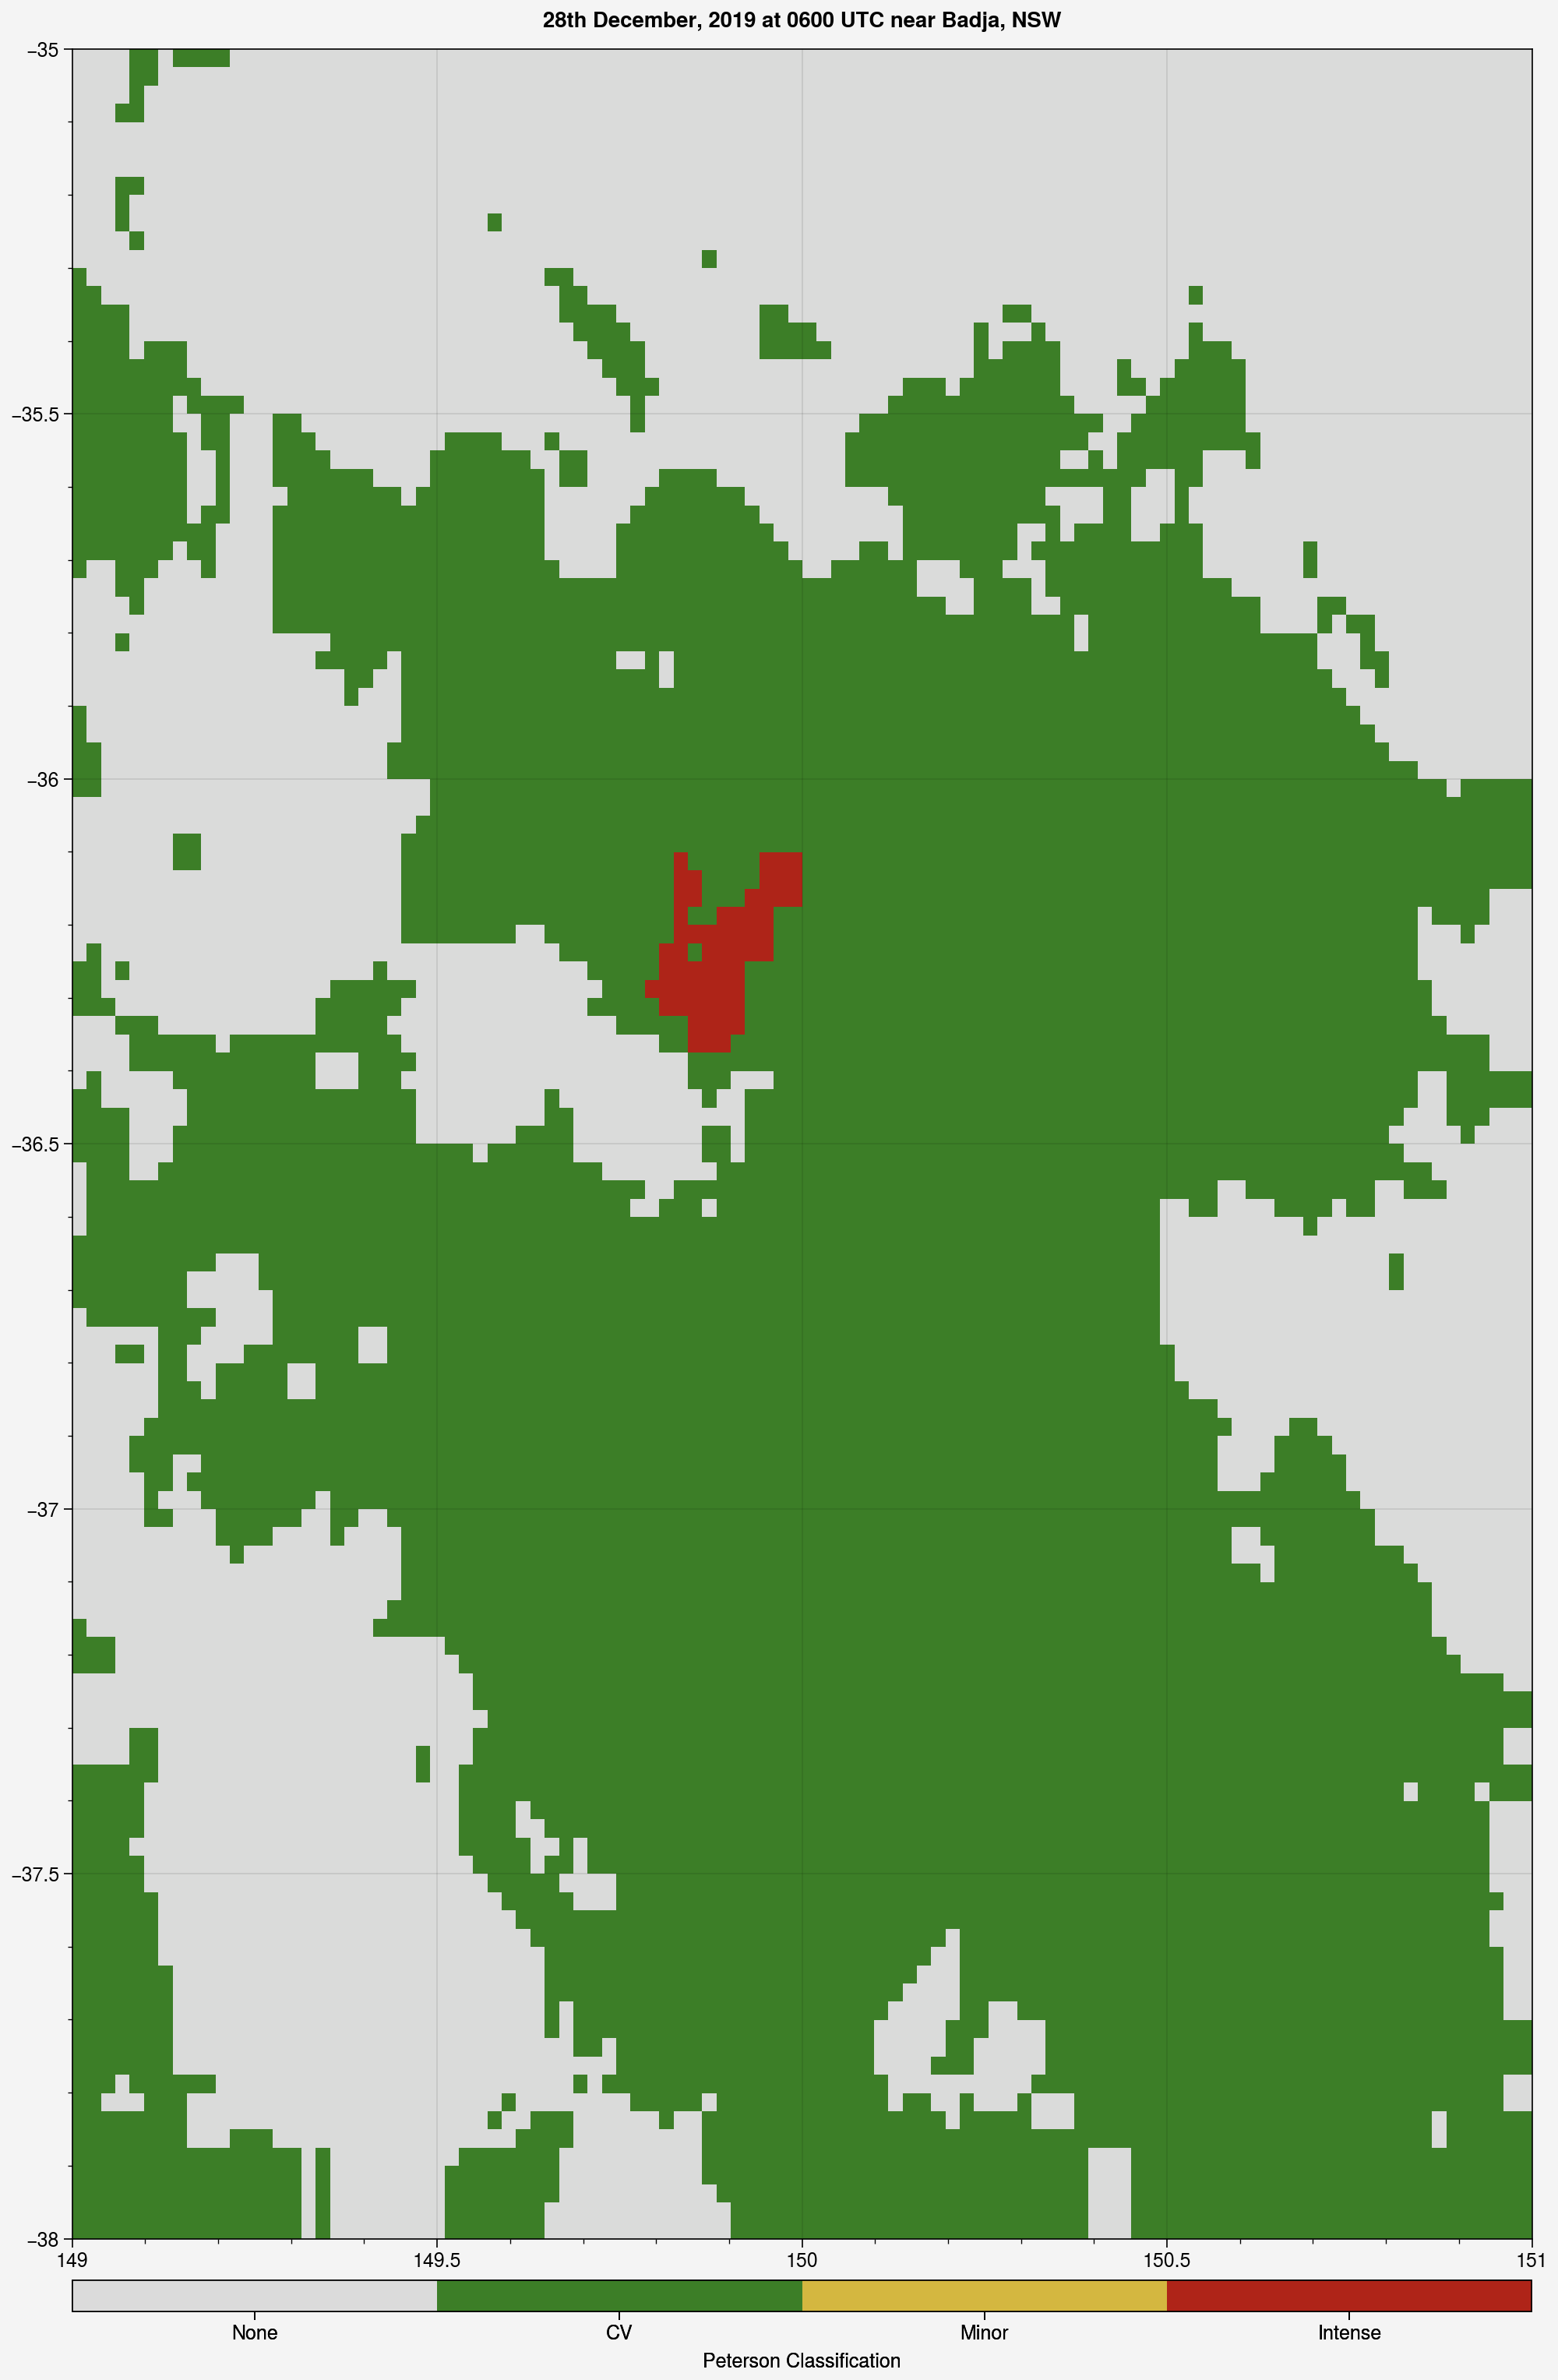

In [81]:
labels = list(("None", "CV", "Minor", "Intense"))
fig, axs = pplt.subplots(ncols=1, nrows=1, width=10, suptitle="28th December, 2019 at 0600 UTC near Badja, NSW", sharex = False, sharey = False)
n = axs[0].imshow(peterson, cmap=md.get_peterson_palette(), vmin=0.5, vmax=4, discrete=True, N=5, extent=[149, 151, -38, -35])
axs[0].colorbar(n, loc='b', ticks=np.arange(0.8, 4.1, 0.8) + 0.4, ticklabels=labels, label="Peterson Classification")
axs[0].format(xminorlocator=0.1, xlocator=0.5, yminorlocator=0.1, ylocator=0.5)